# 1. Introduction

The Acea Group is one of the leading Italian multiutility operators and is the foremost Italian operator in the water services sector supplying 9 million inhabitants in Lazio, Tuscany, Umbria, Molise, Campania.

As it is easy to imagine, a water supply company struggles with the need to forecast the water level in a waterbody (water spring, lake, river, or aquifer) to handle daily consumption. During fall and winter waterbodies are refilled, but during spring and summer they start to drain. To help preserve the health of these waterbodies it is important to predict the most efficient water availability, in terms of level and water flow for each day of the year.

The desired outcome is a notebook that can generate four mathematical models, one for each category of waterbody (acquifers, water springs, river, lake) that might be applicable to each single waterbody.

Four waterbodies (Aquifer Luco, Water Spring Amiata, Lake Bilancino and River Arno) were selected for this notebook. The same approach can be used for other aquifers and water springs.

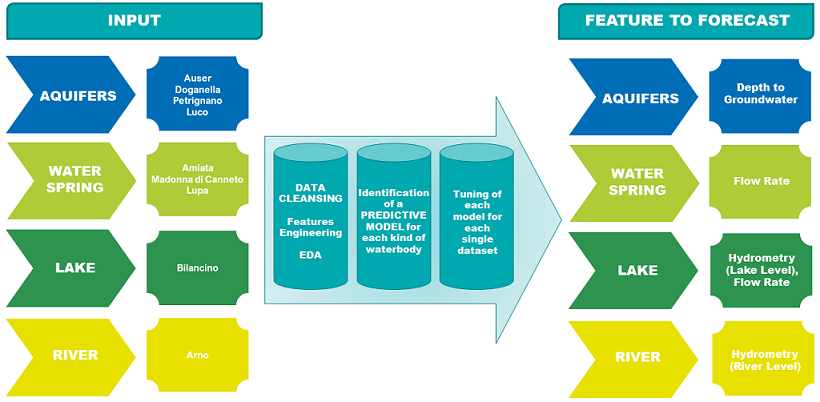

# 2. EDA and Feature Engineering

The objective in this step is to take insights, select predictor variables that have data in the same period as the target variable and create new variables to input in the model.

The [U.S. Geological Survey](https://www.usgs.gov/special-topic/water-science-school/science/a-comprehensive-study-natural-water-cycle?qt-science_center_objects=0#qt-science_center_objects) has a webpage describing the water cycle, we can get some insigths to perform feature engineering. For example, much of the water in rivers and lakes comes from the surface runoff (influenced by the type and saturation of the soil), and in the case of aquifers and underground waterbodies the water arrives through the infiltration, which can take longer to influence the level or flow rate.

Based on these readings we use the accumulation rainfall as a variable, measured in a moving time window. In the case of Lake Bilancino and River Arno the accumulation rainfall in the last 5 days. For Aquifer Luco and Water Spring Lupa, we use a 10 days window to try to capture the effect of the precipitation on the reservoir level and flow rate.

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

input\acea-water-prediction\Aquifer_Auser.csv
input\acea-water-prediction\Aquifer_Doganella.csv
input\acea-water-prediction\Aquifer_Luco.csv
input\acea-water-prediction\Aquifer_Petrignano.csv
input\acea-water-prediction\datasets_description.ods
input\acea-water-prediction\datasets_description.xlsx
input\acea-water-prediction\Lake_Bilancino.csv
input\acea-water-prediction\River_Arno.csv
input\acea-water-prediction\Water_Spring_Amiata.csv
input\acea-water-prediction\Water_Spring_Lupa.csv
input\acea-water-prediction\Water_Spring_Madonna_di_Canneto.csv


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date
from statsmodels.tsa.seasonal import seasonal_decompose
import math
import keras
from keras.models import Model
from keras.layers import Input, Dropout, Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'keras'

In [ ]:
data_luco = pd.read_csv('input/acea-water-prediction/Aquifer_Luco.csv')
data_amiata = pd.read_csv('input/acea-water-prediction/Water_Spring_Amiata.csv')
data_bilancino = pd.read_csv('input/acea-water-prediction/Lake_Bilancino.csv')
data_arno = pd.read_csv('input/acea-water-prediction/River_Arno.csv')

In [ ]:
data_luco['Date'] = pd.to_datetime(data_luco.Date, format = '%d/%m/%Y')
data_amiata['Date'] = pd.to_datetime(data_amiata.Date, format = '%d/%m/%Y')
data_bilancino['Date'] = pd.to_datetime(data_bilancino.Date, format = '%d/%m/%Y')
data_arno['Date'] = pd.to_datetime(data_arno.Date, format = '%d/%m/%Y')

In [ ]:
def plot_missing_values(df, title):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
    sns.heatmap(df.T.isna(), cmap='Blues')
    ax.set_title(f'Missing Data - {title}', fontsize=14)

    plt.show()

    
def missing_data(data):
    missing = data.isnull().sum()
    missingdata = (missing/len(data['Date']))*100
    print(missingdata)

    
def plot_corr_map(df, title):    
    fig, ax = plt.subplots(figsize=(20,10)) 
    ax.set_title(f'Correlation Matrix - {title}', fontsize=14)
    ax = sns.heatmap(df.corr(method='pearson'), vmin=-1, vmax=1, center=0, cmap='Blues', annot=True, square=False)

# 2.1. Aquifer Luco

Description: The Luco wells field is fed by an underground aquifer. This aquifer not fed by rivers or lakes but by meteoric infiltration at the extremes of the impermeable sedimentary layers. Such aquifer is accessed through wells called Well 1, Well 3 and Well 4 and is influenced by the following parameters: rainfall, depth to groundwater, temperature and drainage volumes.

*Target: Depth to Groundwater Podere Casetta, expressed in ground level (meters from the ground floor)*



The first observation is that there are variables with many missing values, one option is to choose between variables similar to the one that has less missing data. The measure used to verify the similarity in this notebook is the Pearson correlation.

The selected precipitation variables Rainfall_Montalcinello, Rainfall_Solvice, Rainfall_Scorgiano, Rainfall_Monteroni_Arbia_Biena, have less missing data and good correlation with the other Rainfall variables.

In [ ]:
plot_missing_values(data_luco, 'Aquifer Luco')

In [ ]:
print('Missing Data (%):')
missing_data(data_luco)

In [ ]:
plot_corr_map(data_luco, 'Aquifer Luco')

In [ ]:
data_luco = data_luco.loc[4545:6945]
data_luco = data_luco[['Date', 'Rainfall_Montalcinello', 'Rainfall_Sovicille', 'Rainfall_Scorgiano', 'Rainfall_Monteroni_Arbia_Biena',
                       'Temperature_Siena_Poggio_al_Vento','Temperature_Mensano', 'Temperature_Pentolina',
                       'Temperature_Monteroni_Arbia_Biena', 'Depth_to_Groundwater_Podere_Casetta']]

Of the selected variables, some presented periods with zero values, in this case we are going to discard the period before 2013, exclusion of temperature variables with many zero values and use linear interpolation to replace the other zero values. Deleting variables is not always the best solution because information is lost, but it was the alternative found for this case.

In [ ]:
fx, ax = plt.subplots(nrows=9, ncols=1, figsize=(15, 20))
fx.suptitle('Original Variables', fontsize=14, y=0.91)
fx.subplots_adjust(hspace=0.5)


sns.lineplot(x=data_luco.Date, y=data_luco.Rainfall_Montalcinello, ax=ax[0], color='darkorange')
sns.lineplot(x=data_luco.Date, y=data_luco.Rainfall_Montalcinello.fillna(np.inf), ax=ax[0])
ax[0].set_title('Rainfall_Montalcinello', fontsize=10)
ax[0].set_ylabel(ylabel=' ')
ax[0].set_xlabel(xlabel=' ')

sns.lineplot(x=data_luco.Date, y=data_luco.Rainfall_Sovicille, ax=ax[1], color='darkorange')
sns.lineplot(x=data_luco.Date, y=data_luco.Rainfall_Sovicille.fillna(np.inf), ax=ax[1])
ax[1].set_title('Rainfall_Sovicille', fontsize=10)
ax[1].set_ylabel(ylabel=' ')
ax[1].set_xlabel(xlabel=' ')

sns.lineplot(x=data_luco.Date, y=data_luco.Rainfall_Scorgiano, ax=ax[2], color='darkorange')
sns.lineplot(x=data_luco.Date, y=data_luco.Rainfall_Scorgiano.fillna(np.inf), ax=ax[2])
ax[2].set_title('Rainfall_Scorgiano', fontsize=10)
ax[2].set_ylabel(ylabel=' ')
ax[2].set_xlabel(xlabel=' ')

sns.lineplot(x=data_luco.Date, y=data_luco.Rainfall_Monteroni_Arbia_Biena, ax=ax[3], color='darkorange')
sns.lineplot(x=data_luco.Date, y=data_luco.Rainfall_Monteroni_Arbia_Biena.fillna(np.inf), ax=ax[3])
ax[3].set_title('Rainfall_Monteroni_Arbia_Biena', fontsize=10)
ax[3].set_ylabel(ylabel=' ')
ax[3].set_xlabel(xlabel=' ')

sns.lineplot(x=data_luco.Date, y=data_luco.Temperature_Siena_Poggio_al_Vento, ax=ax[4], color='darkorange')
sns.lineplot(x=data_luco.Date, y=data_luco.Temperature_Siena_Poggio_al_Vento.fillna(np.inf), ax=ax[4])
ax[4].set_title('Temperature_Siena_Poggio_al_Vento', fontsize=10)
ax[4].set_ylabel(ylabel=' ')
ax[4].set_xlabel(xlabel=' ')

sns.lineplot(x=data_luco.Date, y=data_luco.Temperature_Mensano, ax=ax[5], color='darkorange')
sns.lineplot(x=data_luco.Date, y=data_luco.Temperature_Mensano.fillna(np.inf), ax=ax[5])
ax[5].set_title('Temperature_Mensano', fontsize=10)
ax[5].set_ylabel(ylabel=' ')
ax[5].set_xlabel(xlabel=' ')

sns.lineplot(x=data_luco.Date, y=data_luco.Temperature_Pentolina, ax=ax[6], color='darkorange')
sns.lineplot(x=data_luco.Date, y=data_luco.Temperature_Pentolina.fillna(np.inf), ax=ax[6])
ax[6].set_title('Temperature_Pentolina', fontsize=10)
ax[6].set_ylabel(ylabel=' ')
ax[6].set_xlabel(xlabel=' ')

sns.lineplot(x=data_luco.Date, y=data_luco.Temperature_Monteroni_Arbia_Biena, ax=ax[7], color='darkorange')
sns.lineplot(x=data_luco.Date, y=data_luco.Temperature_Monteroni_Arbia_Biena.fillna(np.inf), ax=ax[7])
ax[7].set_title('Temperature_Monteroni_Arbia_Biena', fontsize=10)
ax[7].set_ylabel(ylabel=' ')
ax[7].set_xlabel(xlabel=' ')

sns.lineplot(x=data_luco.Date, y=data_luco.Depth_to_Groundwater_Podere_Casetta, ax=ax[8], color='darkorange')
sns.lineplot(x=data_luco.Date, y=data_luco.Depth_to_Groundwater_Podere_Casetta.fillna(np.inf), ax=ax[8])
ax[8].set_title('Depth_to_Groundwater_Podere_Casetta', fontsize=10)
ax[8].set_ylabel(ylabel=' ')

for i in range(9):
    ax[i].set_xlim([date(2012, 6, 10), date(2019, 1, 10)])

plt.show()

In [ ]:
data_luco = data_luco.loc[4750:6945]

data_luco['Rainfall_Montalcinello'] = data_luco.Rainfall_Montalcinello.interpolate()
data_luco['Rainfall_Scorgiano'] = data_luco.Rainfall_Scorgiano.interpolate()
data_luco['Depth_to_Groundwater_Podere_Casetta'] = data_luco.Depth_to_Groundwater_Podere_Casetta.interpolate()

data_luco['Temperature_Monteroni_Arbia_Biena']=data_luco['Temperature_Monteroni_Arbia_Biena'].mask(data_luco['Temperature_Monteroni_Arbia_Biena']==0).interpolate()

Regarding the initial data, we will only make a change in the precipitation variables, as mentioned above, we use the accumulated precipitation of the last 10 days for Aquifer Luco and Water Spring Amiata, and 5 days for Lake Bilancino and River Arno.

We also decompose each variable to obtain seasonality and trend in order to capture recurring short and long-term cycles, and also eliminate noise.

In [ ]:
df_luco = data_luco[['Date', 'Temperature_Monteroni_Arbia_Biena', 'Depth_to_Groundwater_Podere_Casetta']]

df_luco['Accumulated_Rainfall_Montalcinello'] = data_luco.Rainfall_Montalcinello.rolling(10).sum()
df_luco['Accumulated_Rainfall_Sovicille'] = data_luco.Rainfall_Sovicille.rolling(10).sum()
df_luco['Accumulated_Rainfall_Scorgiano'] = data_luco.Rainfall_Scorgiano.rolling(10).sum()
df_luco['Accumulated_Rainfall_Monteroni_Arbia_Biena'] = data_luco.Rainfall_Monteroni_Arbia_Biena.rolling(10).sum()
df_luco.dropna(inplace=True)

decompose_columns =  ['Accumulated_Rainfall_Montalcinello', 'Accumulated_Rainfall_Sovicille', 'Accumulated_Rainfall_Scorgiano',
                     'Accumulated_Rainfall_Monteroni_Arbia_Biena', 'Temperature_Monteroni_Arbia_Biena', 'Depth_to_Groundwater_Podere_Casetta']

for column in decompose_columns:
    decompose_data = seasonal_decompose(df_luco[column], freq=52, model='additive', extrapolate_trend='freq')
    df_luco[f"{column}_Trend"] = decompose_data.trend
    df_luco[f"{column}_Seasonal"] = decompose_data.seasonal

df_luco.dropna(inplace=True)
df_luco = df_luco.reset_index(drop=True)

In [ ]:
fx, ax = plt.subplots(nrows=12, ncols=1, figsize=(15, 25))
fx.suptitle('Forecast Variables', fontsize=14, y=0.91)
fx.subplots_adjust(hspace=0.5)

sns.lineplot(x=df_luco.Date, y=df_luco.Accumulated_Rainfall_Montalcinello, ax=ax[0])
sns.lineplot(x=df_luco.Date, y=df_luco.Accumulated_Rainfall_Montalcinello_Trend, label='Trend', ax=ax[0])
ax[0].set_title('Accumulated_Rainfall_Montalcinello', fontsize=10)
ax[0].set_ylabel(ylabel=' ')
ax[0].set_xlabel(xlabel=' ')

sns.lineplot(x=df_luco.Date, y=df_luco.Accumulated_Rainfall_Montalcinello_Seasonal, ax=ax[1])
ax[1].set_title('Accumulated_Rainfall_Montalcinello_Seasonal', fontsize=10)
ax[1].set_ylabel(ylabel=' ')
ax[1].set_xlabel(xlabel=' ')

sns.lineplot(x=df_luco.Date, y=df_luco.Accumulated_Rainfall_Sovicille, ax=ax[2])
sns.lineplot(x=df_luco.Date, y=df_luco.Accumulated_Rainfall_Sovicille_Trend, label='Trend', ax=ax[2])
ax[2].set_title('Accumulated_Rainfall_Sovicille', fontsize=10)
ax[2].set_ylabel(ylabel=' ')
ax[2].set_xlabel(xlabel=' ')

sns.lineplot(x=df_luco.Date, y=df_luco.Accumulated_Rainfall_Sovicille_Seasonal, ax=ax[3])
ax[3].set_title('Accumulated_Rainfall_Sovicille_Seasonal', fontsize=10)
ax[3].set_ylabel(ylabel=' ')
ax[3].set_xlabel(xlabel=' ')

sns.lineplot(x=df_luco.Date, y=df_luco.Accumulated_Rainfall_Scorgiano, ax=ax[4])
sns.lineplot(x=df_luco.Date, y=df_luco.Accumulated_Rainfall_Scorgiano_Trend, label='Trend', ax=ax[4])
ax[4].set_title('Accumulated_Rainfall_Scorgiano', fontsize=10)
ax[4].set_ylabel(ylabel=' ')
ax[4].set_xlabel(xlabel=' ')

sns.lineplot(x=df_luco.Date, y=df_luco.Accumulated_Rainfall_Scorgiano_Seasonal, ax=ax[5])
ax[5].set_title('Accumulated_Rainfall_Scorgiano_Seasonal', fontsize=10)
ax[5].set_ylabel(ylabel=' ')
ax[5].set_xlabel(xlabel=' ')

sns.lineplot(x=df_luco.Date, y=df_luco.Accumulated_Rainfall_Monteroni_Arbia_Biena, ax=ax[6])
sns.lineplot(x=df_luco.Date, y=df_luco.Accumulated_Rainfall_Monteroni_Arbia_Biena_Trend, label='Trend', ax=ax[6])
ax[6].set_title('Accumulated_Rainfall_Monteroni_Arbia_Biena', fontsize=10)
ax[6].set_ylabel(ylabel=' ')
ax[6].set_xlabel(xlabel=' ')

sns.lineplot(x=df_luco.Date, y=df_luco.Accumulated_Rainfall_Monteroni_Arbia_Biena_Seasonal, ax=ax[7])
ax[7].set_title('Accumulated_Rainfall_Monteroni_Arbia_Biena_Seasonal', fontsize=10)
ax[7].set_ylabel(ylabel=' ')
ax[7].set_xlabel(xlabel=' ')

sns.lineplot(x=df_luco.Date, y=df_luco.Temperature_Monteroni_Arbia_Biena, ax=ax[8])
sns.lineplot(x=df_luco.Date, y=df_luco.Temperature_Monteroni_Arbia_Biena_Trend, label='Trend', ax=ax[8])
ax[8].set_title('Temperature_Monteroni_Arbia_Biena', fontsize=10)
ax[8].set_ylabel(ylabel=' ')
ax[8].set_xlabel(xlabel=' ')

sns.lineplot(x=df_luco.Date, y=df_luco.Temperature_Monteroni_Arbia_Biena_Seasonal, ax=ax[9])
ax[9].set_title('Temperature_Monteroni_Arbia_Biena', fontsize=10)
ax[9].set_ylabel(ylabel=' ')
ax[9].set_xlabel(xlabel=' ')

sns.lineplot(x=df_luco.Date, y=df_luco.Depth_to_Groundwater_Podere_Casetta, ax=ax[10])
sns.lineplot(x=df_luco.Date, y=df_luco.Depth_to_Groundwater_Podere_Casetta_Trend, label='Trend', ax=ax[10])
ax[10].set_title('Depth_to_Groundwater_Podere_Casetta', fontsize=10)
ax[10].set_ylabel(ylabel=' ')
ax[10].set_xlabel(xlabel=' ')

sns.lineplot(x=df_luco.Date, y=df_luco.Depth_to_Groundwater_Podere_Casetta_Seasonal, ax=ax[11])
ax[11].set_title('Depth_to_Groundwater_Podere_Casetta_Seasonal', fontsize=10)
ax[11].set_ylabel(ylabel=' ')
ax[11].set_xlabel(xlabel=' ')

for i in range(12):
    ax[i].set_xlim([date(2013, 1, 1), date(2019, 1, 10)])

plt.show()

# 2.2. Water Spring Amiata

Description: The Amiata waterbody is composed of a volcanic aquifer not fed by rivers or lakes but fed by meteoric infiltration. This aquifer is accessed through Ermicciolo, Arbure, Bugnano and Galleria Alta water springs. The levels and volumes of the four sources are influenced by the parameters: rainfall, depth to groundwater, hydrometry, temperatures and drainage volumes.

*Target 1: Flow Rate Bugnano, expressed in liters per second (l/s)*

*Target 2: Flow Rate Arbure, expressed in liters per second (l/s)*

*Target 3: Flow Rate Ermicciolo, expressed in liters per second (l/s)*

*Target 4: Flow Rate Galleria Alta, expressed in liters per second (l/s)*

For the selection of the forecast variables, we use the same approach as the Luco Aquifer, since there are correlated variables, we discard those that have a lot of missing data.

In [ ]:
plot_missing_values(data_amiata, 'Water Spring Amiata')

In [ ]:
print('Missing Data (%):')
missing_data(data_amiata)

In [ ]:
plot_corr_map(data_amiata, 'Water Spring Amiata')

In [ ]:
data_amiata = data_amiata.loc[5480:]

data_amiata = data_amiata[['Date', 'Rainfall_Castel_del_Piano', 'Rainfall_Laghetto_Verde', 'Rainfall_Vetta_Amiata',
                         'Depth_to_Groundwater_David_Lazzaretti', 'Temperature_S_Fiora', 'Flow_Rate_Bugnano', 'Flow_Rate_Arbure',
                         'Flow_Rate_Ermicciolo', 'Flow_Rate_Galleria_Alta']]

Due to the fact that two target variables have zero values in the year 2015, we use the data as of November 2015. For the other zero values we replace with interpolation.

In [ ]:
fx, ax = plt.subplots(nrows=9, ncols=1, figsize=(15, 20))
fx.suptitle('Original Variables', fontsize=14, y=0.91)
fx.subplots_adjust(hspace=0.5)

sns.lineplot(x=data_amiata.Date, y=data_amiata.Rainfall_Castel_del_Piano, ax=ax[0])
ax[0].set_title('Rainfall_Castel_del_Piano', fontsize=10)
ax[0].set_ylabel(ylabel=' ')
ax[0].set_xlabel(xlabel=' ')

sns.lineplot(x=data_amiata.Date, y=data_amiata.Rainfall_Laghetto_Verde, ax=ax[1])
ax[1].set_title('Rainfall_Laghetto_Verde', fontsize=10)
ax[1].set_ylabel(ylabel=' ')
ax[1].set_xlabel(xlabel=' ')

sns.lineplot(x=data_amiata.Date, y=data_amiata.Rainfall_Vetta_Amiata, ax=ax[2])
ax[2].set_title('Rainfall_Vetta_Amiata', fontsize=10)
ax[2].set_ylabel(ylabel=' ')
ax[2].set_xlabel(xlabel=' ')

sns.lineplot(x=data_amiata.Date, y=data_amiata.Depth_to_Groundwater_David_Lazzaretti, ax=ax[3])
ax[3].set_title('Depth_to_Groundwater_David_Lazzaretti', fontsize=10)
ax[3].set_ylabel(ylabel=' ')
ax[3].set_xlabel(xlabel=' ')

sns.lineplot(x=data_amiata.Date, y=data_amiata.Temperature_S_Fiora, ax=ax[4])
ax[4].set_title('Temperature_S_Fiora', fontsize=10)
ax[4].set_ylabel(ylabel=' ')
ax[4].set_xlabel(xlabel=' ')

sns.lineplot(x=data_amiata.Date, y=data_amiata.Flow_Rate_Bugnano, ax=ax[5])
ax[5].set_title('Flow_Rate_Bugnano', fontsize=10)
ax[5].set_ylabel(ylabel=' ')
ax[5].set_xlabel(xlabel=' ')

sns.lineplot(x=data_amiata.Date, y=data_amiata.Flow_Rate_Arbure, ax=ax[6])
ax[6].set_title('Flow_Rate_Arbure', fontsize=10)
ax[6].set_ylabel(ylabel=' ')
ax[6].set_xlabel(xlabel=' ')

sns.lineplot(x=data_amiata.Date, y=data_amiata.Flow_Rate_Ermicciolo, ax=ax[7])
ax[7].set_title('Flow_Rate_Ermicciolo', fontsize=10)
ax[7].set_ylabel(ylabel=' ')
ax[7].set_xlabel(xlabel=' ')

sns.lineplot(x=data_amiata.Date, y=data_amiata.Flow_Rate_Galleria_Alta, ax=ax[8])
ax[8].set_title('Flow_Rate_Galleria_Alta', fontsize=10)
ax[8].set_ylabel(ylabel=' ')

for i in range(9):
    ax[i].set_xlim([date(2015, 1, 1), date(2020, 6, 30)])

plt.show()

In [ ]:
data_amiata['Rainfall_Laghetto_Verde'] = data_amiata['Rainfall_Laghetto_Verde'].interpolate()
data_amiata['Rainfall_Vetta_Amiata'] = data_amiata['Rainfall_Vetta_Amiata'].interpolate()
data_amiata['Depth_to_Groundwater_David_Lazzaretti'] = data_amiata['Depth_to_Groundwater_David_Lazzaretti'].interpolate()

data_amiata['Flow_Rate_Ermicciolo']=data_amiata['Flow_Rate_Ermicciolo'].mask(data_amiata['Flow_Rate_Ermicciolo']==0).interpolate()
data_amiata['Flow_Rate_Bugnano']=data_amiata['Flow_Rate_Bugnano'].mask(data_amiata['Flow_Rate_Bugnano']==0).interpolate()
data_amiata['Flow_Rate_Arbure']=data_amiata['Flow_Rate_Arbure'].mask(data_amiata['Flow_Rate_Arbure']==0).interpolate()

In [ ]:
df_amiata = data_amiata.loc[5780:]

df_amiata['Accumulated_Rainfall_Castel_del_Piano'] = df_amiata['Rainfall_Castel_del_Piano'].rolling(10).sum()
df_amiata['Accumulated_Rainfall_Laghetto_Verde'] = df_amiata['Rainfall_Laghetto_Verde'].rolling(10).sum()
df_amiata['Accumulated_Rainfall_Vetta_Amiata'] = df_amiata['Rainfall_Vetta_Amiata'].rolling(10).sum()

df_amiata = df_amiata.drop(['Rainfall_Castel_del_Piano', 'Rainfall_Laghetto_Verde', 'Rainfall_Vetta_Amiata'], axis=1)
df_amiata.dropna(inplace=True)

decompose_columns =  ['Accumulated_Rainfall_Castel_del_Piano', 'Accumulated_Rainfall_Laghetto_Verde', 'Accumulated_Rainfall_Vetta_Amiata',
                      'Depth_to_Groundwater_David_Lazzaretti', 'Temperature_S_Fiora', 'Flow_Rate_Bugnano', 'Flow_Rate_Arbure',
                      'Flow_Rate_Ermicciolo', 'Flow_Rate_Galleria_Alta']

for column in decompose_columns:
    decompose_data = seasonal_decompose(df_amiata[column], freq=52, model='additive', extrapolate_trend='freq')
    df_amiata[f"{column}_Trend"] = decompose_data.trend
    df_amiata[f"{column}_Seasonal"] = decompose_data.seasonal

df_amiata.dropna(inplace=True)
df_amiata = df_amiata.reset_index(drop=True)

In [ ]:
fx, ax = plt.subplots(nrows=18, ncols=1, figsize=(15, 30))
fx.suptitle('Forecast Variables', fontsize=14, y=0.90)
fx.subplots_adjust(hspace=0.5)

sns.lineplot(x=df_amiata.Date, y=df_amiata.Accumulated_Rainfall_Castel_del_Piano, ax=ax[0])
sns.lineplot(x=df_amiata.Date, y=df_amiata.Accumulated_Rainfall_Castel_del_Piano_Trend, label='Trend', ax=ax[0])
ax[0].set_title('Accumulated_Rainfall_Castel_del_Piano', fontsize=10)
ax[0].set_ylabel(ylabel=' ')
ax[0].set_xlabel(xlabel=' ')

sns.lineplot(x=df_amiata.Date, y=df_amiata.Accumulated_Rainfall_Castel_del_Piano_Seasonal, ax=ax[1])
ax[1].set_title('Accumulated_Rainfall_Castel_del_Piano_Seasonal', fontsize=10)
ax[1].set_ylabel(ylabel=' ')
ax[1].set_xlabel(xlabel=' ')

sns.lineplot(x=df_amiata.Date, y=df_amiata.Accumulated_Rainfall_Laghetto_Verde, ax=ax[2])
sns.lineplot(x=df_amiata.Date, y=df_amiata.Accumulated_Rainfall_Laghetto_Verde_Trend, label='Trend', ax=ax[2])
ax[2].set_title('Accumulated_Rainfall_Laghetto_Verde', fontsize=10)
ax[2].set_ylabel(ylabel=' ')
ax[2].set_xlabel(xlabel=' ')

sns.lineplot(x=df_amiata.Date, y=df_amiata.Accumulated_Rainfall_Laghetto_Verde_Seasonal, ax=ax[3])
ax[3].set_title('Accumulated_Rainfall_Laghetto_Verde_Seasonal', fontsize=10)
ax[3].set_ylabel(ylabel=' ')
ax[3].set_xlabel(xlabel=' ')

sns.lineplot(x=df_amiata.Date, y=df_amiata.Accumulated_Rainfall_Vetta_Amiata, ax=ax[4])
sns.lineplot(x=df_amiata.Date, y=df_amiata.Accumulated_Rainfall_Vetta_Amiata_Trend, label='Trend', ax=ax[4])
ax[4].set_title('Accumulated_Rainfall_Vetta_Amiata', fontsize=10)
ax[4].set_ylabel(ylabel=' ')
ax[4].set_xlabel(xlabel=' ')

sns.lineplot(x=df_amiata.Date, y=df_amiata.Accumulated_Rainfall_Vetta_Amiata_Seasonal, ax=ax[5])
ax[5].set_title('Accumulated_Rainfall_Vetta_Amiata_Seasonal', fontsize=10)
ax[5].set_ylabel(ylabel=' ')
ax[5].set_xlabel(xlabel=' ')

sns.lineplot(x=df_amiata.Date, y=df_amiata.Depth_to_Groundwater_David_Lazzaretti, ax=ax[6])
sns.lineplot(x=df_amiata.Date, y=df_amiata.Depth_to_Groundwater_David_Lazzaretti_Trend, label='Trend', ax=ax[6])
ax[6].set_title('Depth_to_Groundwater_David_Lazzaretti', fontsize=10)
ax[6].set_ylabel(ylabel=' ')
ax[6].set_xlabel(xlabel=' ')

sns.lineplot(x=df_amiata.Date, y=df_amiata.Depth_to_Groundwater_David_Lazzaretti_Seasonal, ax=ax[7])
ax[7].set_title('Depth_to_Groundwater_David_Lazzaretti_Seasonal', fontsize=10)
ax[7].set_ylabel(ylabel=' ')
ax[7].set_xlabel(xlabel=' ')

sns.lineplot(x=df_amiata.Date, y=df_amiata.Temperature_S_Fiora, ax=ax[8])
sns.lineplot(x=df_amiata.Date, y=df_amiata.Temperature_S_Fiora_Trend, label='Trend', ax=ax[8])
ax[8].set_title('Temperature_S_Fiora', fontsize=10)
ax[8].set_ylabel(ylabel=' ')
ax[8].set_xlabel(xlabel=' ')

sns.lineplot(x=df_amiata.Date, y=df_amiata.Temperature_S_Fiora_Seasonal, ax=ax[9])
ax[9].set_title('Temperature_S_Fiora_Seasonal', fontsize=10)
ax[9].set_ylabel(ylabel=' ')
ax[9].set_xlabel(xlabel=' ')

sns.lineplot(x=df_amiata.Date, y=df_amiata.Flow_Rate_Bugnano, ax=ax[10])
sns.lineplot(x=df_amiata.Date, y=df_amiata.Flow_Rate_Bugnano_Trend, label='Trend', ax=ax[10])
ax[10].set_title('Flow_Rate_Bugnano', fontsize=10)
ax[10].set_ylabel(ylabel=' ')
ax[10].set_xlabel(xlabel=' ')

sns.lineplot(x=df_amiata.Date, y=df_amiata.Flow_Rate_Bugnano_Seasonal, ax=ax[11])
ax[11].set_title('Flow_Rate_Bugnano_Seasonal', fontsize=10)
ax[11].set_ylabel(ylabel=' ')
ax[11].set_xlabel(xlabel=' ')

sns.lineplot(x=df_amiata.Date, y=df_amiata.Flow_Rate_Arbure, ax=ax[12])
sns.lineplot(x=df_amiata.Date, y=df_amiata.Flow_Rate_Arbure_Trend, label='Trend', ax=ax[12])
ax[12].set_title('Flow_Rate_Arbure', fontsize=10)
ax[12].set_ylabel(ylabel=' ')
ax[12].set_xlabel(xlabel=' ')

sns.lineplot(x=df_amiata.Date, y=df_amiata.Flow_Rate_Arbure_Seasonal, ax=ax[13])
ax[13].set_title('Flow_Rate_Arbure_Seasonal', fontsize=10)
ax[13].set_ylabel(ylabel=' ')
ax[13].set_xlabel(xlabel=' ')

sns.lineplot(x=df_amiata.Date, y=df_amiata.Flow_Rate_Ermicciolo, ax=ax[14])
sns.lineplot(x=df_amiata.Date, y=df_amiata.Flow_Rate_Ermicciolo_Trend, label='Trend', ax=ax[14])
ax[14].set_title('Flow_Rate_Ermicciolo', fontsize=10)
ax[14].set_ylabel(ylabel=' ')
ax[14].set_xlabel(xlabel=' ')

sns.lineplot(x=df_amiata.Date, y=df_amiata.Flow_Rate_Ermicciolo_Seasonal, ax=ax[15])
ax[15].set_title('Flow_Rate_Ermicciolo_Seasonal', fontsize=10)
ax[15].set_ylabel(ylabel=' ')
ax[15].set_xlabel(xlabel=' ')

sns.lineplot(x=df_amiata.Date, y=df_amiata.Flow_Rate_Galleria_Alta, ax=ax[16])
sns.lineplot(x=df_amiata.Date, y=df_amiata.Flow_Rate_Galleria_Alta_Trend, label='Trend', ax=ax[16])
ax[16].set_title('Flow_Rate_Galleria_Alta', fontsize=10)
ax[16].set_ylabel(ylabel=' ')
ax[16].set_xlabel(xlabel=' ')

sns.lineplot(x=df_amiata.Date, y=df_amiata.Flow_Rate_Galleria_Alta_Seasonal, ax=ax[17])
ax[17].set_title('Flow_Rate_Galleria_Alta_Seasonal', fontsize=10)
ax[17].set_ylabel(ylabel=' ')

for i in range(18):
    ax[i].set_xlim([date(2015, 10, 28), date(2020, 6, 30)])

plt.show()

# 2.3. Lake Bilancino

Description: Bilancino lake is an artificial lake located in the municipality of Barberino di Mugello (about 50 km from Florence). It is used to refill the Arno river during the summer months. Indeed, during the winter months, the lake is filled up and then, during the summer months, the water of the lake is poured into the Arno river.

*Target 1: Lake Level, expressed in meters (m)*

*Target 2: Flow Rate, expressed in cubic meters per seconds (mc/s)*

In [ ]:
plot_missing_values(data_bilancino, 'Lake Bilancino')

In [ ]:
print('Missing Data (%):')
missing_data(data_bilancino)

In [ ]:
plot_corr_map(data_bilancino, 'Lake Bilancino')

In the case of Lake Bilancino, we use the data from 2004 onwards and select the Rainfall_S_Piero which has a strong correlation with the other precipitation variables.

In [ ]:
fx, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 10))
fx.suptitle('Original Variables', fontsize=14, y=0.95)
fx.subplots_adjust(hspace=0.5)

sns.lineplot(x=data_bilancino.Date, y=data_bilancino.Rainfall_S_Piero, ax=ax[0], color='darkorange')
sns.lineplot(x=data_bilancino.Date, y=data_bilancino.Rainfall_S_Piero.fillna(np.inf), ax=ax[0])
ax[0].set_title('Rainfall_S_Piero', fontsize=10)
ax[0].legend(loc='best', fontsize=8)
ax[0].set_ylabel(ylabel=' ')
ax[0].set_xlabel(xlabel=' ')

sns.lineplot(x=data_bilancino.Date, y=data_bilancino.Temperature_Le_Croci, ax=ax[1], color='darkorange')
sns.lineplot(x=data_bilancino.Date, y=data_bilancino.Temperature_Le_Croci.fillna(np.inf), ax=ax[1])
ax[1].set_title('Temperature_Le_Croci', fontsize=10)
ax[1].set_ylabel(ylabel=' ')
ax[1].set_xlabel(xlabel=' ')


sns.lineplot(x=data_bilancino.Date, y=data_bilancino.Lake_Level, ax=ax[2], color='darkorange')
sns.lineplot(x=data_bilancino.Date, y=data_bilancino.Lake_Level.fillna(np.inf), ax=ax[2])
ax[2].set_title('Lake_Level', fontsize=10)
ax[2].legend(loc='best', fontsize=8)
ax[2].set_ylabel(ylabel=' ')
ax[2].set_xlabel(xlabel=' ')


sns.lineplot(x=data_bilancino.Date, y=data_bilancino.Flow_Rate, ax=ax[3], color='darkorange')
sns.lineplot(x=data_bilancino.Date, y=data_bilancino.Flow_Rate.fillna(np.inf), ax=ax[3])
ax[3].set_title('Flow_Rate', fontsize=10)
ax[3].legend(loc='best', fontsize=8)
ax[3].set_ylabel(ylabel=' ')

for i in range(4):
    ax[i].set_xlim([date(2002, 6, 1), date(2020, 6, 30)])

plt.show()

In [ ]:
df_bilancino = data_bilancino[['Date', 'Temperature_Le_Croci', 'Lake_Level', 'Flow_Rate']]
df_bilancino['Accumulated_Rainfall'] = data_bilancino['Rainfall_S_Piero'].rolling(5).sum()
df_bilancino.dropna(inplace=True)

decompose_columns =  ['Accumulated_Rainfall', 'Temperature_Le_Croci', 'Lake_Level', 'Flow_Rate']

for column in decompose_columns:
    decompose_data = seasonal_decompose(df_bilancino[column], freq=52, model='additive', extrapolate_trend='freq')
    df_bilancino[f"{column}_Trend"] = decompose_data.trend
    df_bilancino[f"{column}_Seasonal"] = decompose_data.seasonal

df_bilancino.dropna(inplace=True)
df_bilancino = df_bilancino.reset_index(drop=True)

In [ ]:
fx, ax = plt.subplots(nrows=8, ncols=1, figsize=(15, 20))
fx.suptitle('Forecast Variables', fontsize=14, y=0.91)
fx.subplots_adjust(hspace=0.5)

sns.lineplot(x=df_bilancino.Date, y=df_bilancino.Accumulated_Rainfall, ax=ax[0])
sns.lineplot(x=df_bilancino.Date, y=df_bilancino.Accumulated_Rainfall_Trend, label='Trend', ax=ax[0])
ax[0].set_title('Accumulated_Rainfall', fontsize=10)
ax[0].legend(loc='best', fontsize=8)
ax[0].set_ylabel(ylabel=' ')
ax[0].set_xlabel(xlabel=' ')

sns.lineplot(x=df_bilancino.Date, y=df_bilancino.Accumulated_Rainfall_Seasonal, ax=ax[1])
ax[1].set_title('Accumulated_Rainfall_Seasonal', fontsize=10)
ax[1].set_ylabel(ylabel=' ')
ax[1].set_xlabel(xlabel=' ')

sns.lineplot(x=df_bilancino.Date, y=df_bilancino.Temperature_Le_Croci, ax=ax[2])
sns.lineplot(x=df_bilancino.Date, y=df_bilancino.Temperature_Le_Croci_Trend, label='Trend', ax=ax[2])
ax[2].set_title('Temperature_Le_Croci', fontsize=10)
ax[0].legend(loc='best', fontsize=8)
ax[2].set_ylabel(ylabel=' ')
ax[2].set_xlabel(xlabel=' ')

sns.lineplot(x=df_bilancino.Date, y=df_bilancino.Temperature_Le_Croci_Seasonal, ax=ax[3])
ax[3].set_title('Temperature_Le_Croci_Seasonal', fontsize=10)
ax[3].set_ylabel(ylabel=' ')
ax[3].set_xlabel(xlabel=' ')

sns.lineplot(x=df_bilancino.Date, y=df_bilancino.Lake_Level, ax=ax[4])
sns.lineplot(x=df_bilancino.Date, y=df_bilancino.Lake_Level_Trend, label='Trend', ax=ax[4])
ax[4].set_title('Lake_Level', fontsize=10)
ax[0].legend(loc='best', fontsize=8)
ax[4].set_ylabel(ylabel=' ')
ax[4].set_xlabel(xlabel=' ')

sns.lineplot(x=df_bilancino.Date, y=df_bilancino.Lake_Level_Seasonal, ax=ax[5])
ax[5].set_title('Lake_Level_Seasonal', fontsize=10)
ax[5].set_ylabel(ylabel=' ')
ax[5].set_xlabel(xlabel=' ')

sns.lineplot(x=df_bilancino.Date, y=df_bilancino.Flow_Rate, ax=ax[6])
sns.lineplot(x=df_bilancino.Date, y=df_bilancino.Flow_Rate_Trend, label='Trend', ax=ax[6])
ax[6].set_title('Flow_Rate', fontsize=10)
ax[0].legend(loc='best', fontsize=8)
ax[6].set_ylabel(ylabel=' ')
ax[6].set_xlabel(xlabel=' ')

sns.lineplot(x=df_bilancino.Date, y=df_bilancino.Flow_Rate_Seasonal, ax=ax[7])
ax[7].set_title('Flow_Rate_Seasonal', fontsize=10)
ax[7].set_ylabel(ylabel=' ')

for i in range(8):
    ax[i].set_xlim([date(2004, 1, 1), date(2020, 6, 30)])

plt.show()

# 2.4. River Arno

* **River Arno**

Description: Arno is the second largest river in peninsular Italy and the main waterway in Tuscany and it has a relatively torrential regime, due to the nature of the surrounding soils (marl and impermeable clays). Arno results to be the main source of water supply of the metropolitan area of Florence-Prato-Pistoia. The availability of water for this waterbody is evaluated by checking the hydrometric level of the river at the section of Nave di Rosano.

*Target: Hydrometry Nave di Rosano, expressed in meters (m)*

In [ ]:
plot_missing_values(data_arno, 'River Arno')

In [ ]:
print('Missing Data (%):')
missing_data(data_arno)

In [ ]:
plot_corr_map(data_arno, 'River Arno')

Looking at the correlation matrix, we have two correlated groups of rainfall. Through a brief search on Google Maps we have discovered why there are two rainfall groups. Vernio, Mangona, Cavallina, Le_Croci, S_Agata and S_Piero are to the north of Firenze, near to Lake Bilancino, these precipitations reach the River Arno through the River Sieve. The other points are located to the southeast of Firenze and fall directly into the Arno riverbed.

We selected Rainfall_S_Piero to represent precipitation in the north and Rainfall_Incisa for precipitation in the south.

In [ ]:
fx, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 10))
fx.suptitle('Original Variables', fontsize=14, y=0.95)
fx.subplots_adjust(hspace=0.5)

sns.lineplot(x=data_arno.Date, y=data_arno.Rainfall_S_Piero, ax=ax[0], color='darkorange')
sns.lineplot(x=data_arno.Date, y=data_arno.Rainfall_S_Piero.fillna(np.inf), ax=ax[0])
ax[0].legend(loc='best', fontsize=8)
ax[0].set_title('Rainfall_S_Piero', fontsize=10)
ax[0].set_ylabel(ylabel=' ')
ax[0].set_xlabel(xlabel=' ')

sns.lineplot(x=data_arno.Date, y=data_arno.Rainfall_Incisa, ax=ax[1], color='darkorange')
sns.lineplot(x=data_arno.Date, y=data_arno.Rainfall_Incisa.fillna(np.inf), ax=ax[1])
ax[1].set_title('Rainfall_Incisa', fontsize=10)
ax[1].set_ylabel(ylabel=' ')
ax[1].set_xlabel(xlabel=' ')

sns.lineplot(x=data_arno.Date, y=data_arno.Temperature_Firenze, ax=ax[2], color='darkorange')
sns.lineplot(x=data_arno.Date, y=data_arno.Temperature_Firenze.fillna(np.inf), ax=ax[2])
ax[2].legend(loc='best', fontsize=8)
ax[2].set_title('Temperature_Firenze', fontsize=10)
ax[2].set_ylabel(ylabel=' ')
ax[2].set_xlabel(xlabel=' ')

sns.lineplot(x=data_arno.Date, y=data_arno.Hydrometry_Nave_di_Rosano, ax=ax[3], color='darkorange')
sns.lineplot(x=data_arno.Date, y=data_arno.Hydrometry_Nave_di_Rosano.fillna(np.inf), ax=ax[3])
ax[3].set_title('Hydrometry_Nave_di_Rosano', fontsize=10)
ax[3].set_ylabel(ylabel=' ')

for i in range(4):
    ax[i].set_xlim([date(2002, 6, 1), date(2020, 6, 30)])

plt.show()

We select the data between 2004 and 2016, and use interpolation to replace the missing and zero values.

In [ ]:
df_arno = data_arno[['Date', 'Temperature_Firenze', 'Hydrometry_Nave_di_Rosano', 'Rainfall_S_Piero', 'Rainfall_Incisa']]

df_arno['Accumulated_Rainfall_North'] = df_arno['Rainfall_S_Piero'].rolling(5).sum()
df_arno['Accumulated_Rainfall_South'] = df_arno['Rainfall_Incisa'].rolling(5).sum()
df_arno = df_arno.drop(['Rainfall_S_Piero', 'Rainfall_Incisa'], axis=1)
df_arno.dropna(inplace=True)

df_arno['Hydrometry_Nave_di_Rosano']=df_arno['Hydrometry_Nave_di_Rosano'].mask(df_arno['Hydrometry_Nave_di_Rosano']==0).interpolate()

decompose_columns =  ['Accumulated_Rainfall_North', 'Accumulated_Rainfall_South', 'Temperature_Firenze', 'Hydrometry_Nave_di_Rosano']

for column in decompose_columns:
    decompose_data = seasonal_decompose(df_arno[column], freq=52, model='additive', extrapolate_trend='freq')
    df_arno[f"{column}_Trend"] = decompose_data.trend
    df_arno[f"{column}_Seasonal"] = decompose_data.seasonal

df_arno.dropna(inplace=True)
df_arno = df_arno.reset_index(drop=True)

In [ ]:
fx, ax = plt.subplots(nrows=8, ncols=1, figsize=(15, 20))
fx.suptitle('Forecast Variables', fontsize=14, y=0.92)
fx.subplots_adjust(hspace=0.5)

sns.lineplot(x=df_arno.Date, y=df_arno.Accumulated_Rainfall_North, ax=ax[0])
sns.lineplot(x=df_arno.Date, y=df_arno.Accumulated_Rainfall_North_Trend, label='trend', ax=ax[0])
ax[0].legend(loc='best', fontsize=8)
ax[0].set_title('Accumulated_Rainfall_North', fontsize=10)
ax[0].set_ylabel(ylabel=' ')
ax[0].set_xlabel(xlabel=' ')

sns.lineplot(x=df_arno.Date, y=df_arno.Accumulated_Rainfall_North_Seasonal, ax=ax[1])
ax[1].set_title('Accumulated_Rainfall_North_Seasonal', fontsize=10)
ax[1].set_ylabel(ylabel=' ')
ax[1].set_xlabel(xlabel=' ')

sns.lineplot(x=df_arno.Date, y=df_arno.Accumulated_Rainfall_South, ax=ax[2])
sns.lineplot(x=df_arno.Date, y=df_arno.Accumulated_Rainfall_South_Trend, label='trend', ax=ax[2])
ax[2].legend(loc='best', fontsize=8)
ax[2].set_title('Accumulated_Rainfall_South', fontsize=10)
ax[2].set_ylabel(ylabel=' ')
ax[2].set_xlabel(xlabel=' ')

sns.lineplot(x=df_arno.Date, y=df_arno.Accumulated_Rainfall_South_Seasonal, ax=ax[3])
ax[3].set_title('Accumulated_Rainfall_South_Seasonal', fontsize=10)
ax[3].set_ylabel(ylabel=' ')
ax[3].set_xlabel(xlabel=' ')

sns.lineplot(x=df_arno.Date, y=df_arno.Temperature_Firenze, ax=ax[4])
sns.lineplot(x=df_arno.Date, y=df_arno.Temperature_Firenze_Trend, label='trend', ax=ax[4])
ax[4].legend(loc='best', fontsize=8)
ax[4].set_title('Temperature_Firenze', fontsize=10)
ax[4].set_ylabel(ylabel=' ')
ax[4].set_xlabel(xlabel=' ')

sns.lineplot(x=df_arno.Date, y=df_arno.Temperature_Firenze_Seasonal, ax=ax[5])
ax[5].set_title('Temperature_Firenze_Seasonal', fontsize=10)
ax[5].set_ylabel(ylabel=' ')
ax[5].set_xlabel(xlabel=' ')

sns.lineplot(x=df_arno.Date, y=df_arno.Hydrometry_Nave_di_Rosano, ax=ax[6])
sns.lineplot(x=df_arno.Date, y=df_arno.Hydrometry_Nave_di_Rosano_Trend, label='trend', ax=ax[6])
ax[6].legend(loc='best', fontsize=8)
ax[6].set_title('Hydrometry_Nave_di_Rosano', fontsize=10)
ax[6].set_ylabel(ylabel=' ')
ax[6].set_xlabel(xlabel=' ')

sns.lineplot(x=df_arno.Date, y=df_arno.Hydrometry_Nave_di_Rosano_Seasonal, ax=ax[7])
ax[7].set_title('Hydrometry_Nave_di_Rosano_Seasonal', fontsize=10)
ax[7].set_ylabel(ylabel=' ')

for i in range(8):
    ax[i].set_xlim([date(2004, 1, 1), date(2016, 7, 4)])

plt.show()

# 3. The Model - LSTM

[Long short-term memory](https://en.wikipedia.org/wiki/Long_short-term_memory) (LSTM) is an artificial recurrent neural network (RNN) architecture. Unlike standard feedforward neural networks, LSTM has feedback connections (sliding window), being able to keep track of arbitrary long short-term dependencies in the input sequences.

This neural network has two LSTM layers with 20 neurons each, it is configured not to use the previous state (stateful) as an input to calculate the current state.

The LSTM entry must be three-dimensional data (samples, timesteps, features): 
* Samples = Number of rows 
* Timesteps = Sliding window, number of days used to predict the target, for example if timesteps=30 the model will use data from the previous 30 days to predict the next day 
* Features = number of predictor variables


* **Train Test Split**
The division between training and test data is done continuously, for example, if tain_size = 0.70, the model will use 0% to 70% of the data for training and the rest for testing.


* **Sliding Window**
This is one of the reasons why we chose LSTM to model a multivariate time series. If days_ahead set to 1 and timestep set to 25 days (t=24). The neural network will use data (of all variables) from the last 24 days (t=0 until t=23) to predict the target on the 25th day (t=24). If days_ahead set to 7, the model will use the first 24 days to predict the 32nd day (t = 31).

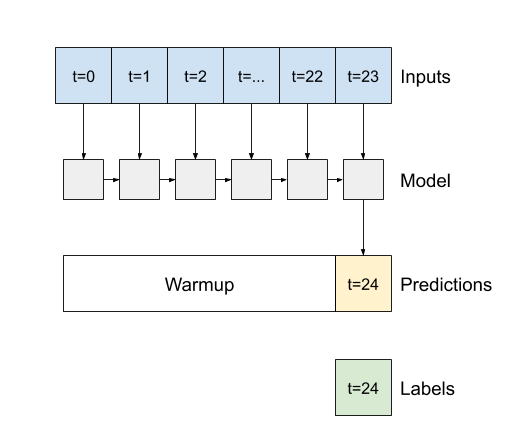
Sliding window - Image take from [Tensorflow website](https://www.tensorflow.org/tutorials/structured_data/time_series).

In [ ]:
class DataTransform():

    def __init__(self, df, target_column):
        '''
        df: DataFrame with non-normalized data
        target_column: title referring to target column
        '''
        self.df = df.select_dtypes(include=['float64', 'int64'])
        self.scaler = MinMaxScaler(feature_range = (0, 1))
        self.target_column = target_column
    
    def normalize(self):
        df_norm = self.scaler.fit_transform(self.df.values)
        self.df_norm = pd.DataFrame(df_norm, index=self.df.index, columns=self.df.columns)
        
        return self.df_norm

# Split the data into training and testing
    def train_test_split(self, train_size=0.7):
        '''
        train_size: percentage of DataFrame for training
        '''
        train_test = int(len(self.df_norm)*train_size)
        df_train, df_test = self.df_norm[0:train_test], self.df_norm[train_test:len(self.df_norm)]

        df_train.dropna(inplace=True)
        df_train = df_train.reset_index(drop=True)
        df_test.dropna(inplace=True)
        df_test = df_test.reset_index(drop=True)
        
        return df_train, df_test
    
# Apply the sliding window to the data
    def sliding_window(self, data, days_ahead=1, timesteps=1):
        '''
        days_ahead: number of days for target prediction
        timesteps: period of LSTM window
        '''
        data = data.select_dtypes(include=['float64', 'int64'])
        days_ahead -= 1
        dataA, dataB = [], []

        for i in range(len(data)-(timesteps+days_ahead)):
            a = data[i:(i+timesteps)].to_numpy()
            dataA.append(a)
            dataB.append(data[self.target_column].loc[[i+days_ahead+timesteps]].to_numpy())

        self.X, self.Y_target = np.asarray(dataA, dtype=np.float32), np.asarray(dataB, dtype=np.float32)
        
        return self.X, self.Y_target
    
# Reverses normalization
    def inverse_norm(self, data, multi_dim=False):
        '''
        multi_dim: True if the data (array) has more than 2 dimensions
        '''
        if multi_dim:
            mc_dropout = []
        
            for i in range(data.shape[0]):

                mc_dropout_dataset = np.zeros(shape=(len(data[i]), self.X.shape[2]))
                mc_dropout_dataset[:,self.df.columns.get_loc(self.target_column)] = data[i][:,0]
                mc_dropout.append(self.scaler.inverse_transform(mc_dropout_dataset)[:,self.df.columns.get_loc(self.target_column)])

            mc_dropout = np.array(mc_dropout)

            return mc_dropout
        
        else:
            prev_dataset = np.zeros(shape=(len(data), self.X.shape[2]))
            prev_dataset[:,self.df.columns.get_loc(self.target_column)] = data[:,0]
            data = self.scaler.inverse_transform(prev_dataset)[:,self.df.columns.get_loc(self.target_column)]

            return data

* **Prediction Intervals**

Hardly any model will make an accurate prediction of the target, so it is important to have an estimate of uncertainty to facilitate the interpretation of the result. Inspired by the [Uber](https://eng.uber.com/neural-networks-uncertainty-estimation/) article we use the dropout to create a prediction interval.

The dropout when applied during training turns off a fraction of the network's neurons, and aims to increase the generalization of the model.

In this case, we turn off a fraction of the neurons at the time of the forecast to generate a distribution of N "random" forecasts, and through the quantiles of the calculated distribution we obtain the forecast range.

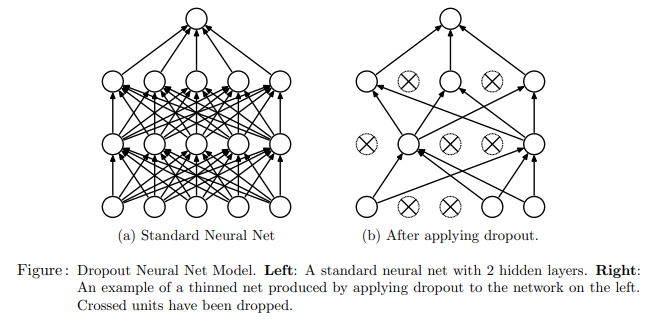
Image taken from [Srivastava et al. 2014.](https://jmlr.org/papers/v15/srivastava14a.html)

In [ ]:
class BlueGoldPredict():

# LSTM training function, the test input data is for calculating the loss   
    def training(self, X_train, Y_train, X_test, Y_test, epochs=50, verbose=0):
        '''
        epochs: number of epochs of LSTM
        verbose: show the progress bar
        '''
        inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
        x = LSTM(20, return_sequences=True)(inputs, training=True)
        x = LSTM(20)(x, training=True)
        outputs = Dense(1)(x)

        self.model = Model(inputs, outputs) 
        self.model.compile(loss='mean_squared_error', optimizer='adam')

        self.history = self.model.fit(X_train, Y_train, epochs=epochs, batch_size=1, validation_data=(X_test, Y_test), verbose=verbose)
              
        return self.history
    
# Plot the history of loss of training and test data    
    def plot_loss(self):
        fig, ax = plt.subplots(figsize=(10,5))
        ax.set_title('Cost function', fontsize=14)
        plt.plot(self.history.history['loss'], label='train')
        plt.plot(self.history.history['val_loss'], label='test')
        ax.set_ylabel('Loss', fontsize=14)
        ax.set_xlabel('Epochs', fontsize=14)
        plt.legend(loc='best', fontsize=14)
        plt.show()
    
# Performs prediction for input data X    
    def predict(self, X):
      
        predict = self.model.predict(X, batch_size=1)
        
        return predict
    
# Performs N random predictions (sample_size), turning off the reported neuron fraction (dropout_uncertainty)
    def predict_interval(self, X, sample_size=100, dropout_uncertainty=0.1):
        '''
        sample_size: amount of random samples
        dropout_uncertainty: fraction of layers that are turned off for the generation of uncertainty samples
        '''
        conf = self.model.get_config()
        
        for layer in conf['layers']:
            if layer['class_name']=='Dropout':
                layer['config']['rate'] = dropout_uncertainty
            elif 'dropout' in layer['config'].keys():
                layer['config']['dropout'] = dropout_uncertainty
        
        model_2 = Model.from_config(conf)
        model_2.set_weights(self.model.get_weights())
        
        model_dropout = Model(inputs=model_2.inputs, outputs=model_2.outputs)
        
        pred_dropout = []

        for i in range(sample_size):
            pred_dropout.append(model_dropout.predict(X, batch_size=1))
        
        pred_dropout = np.array(pred_dropout)
        
        return pred_dropout

* **How to choose the best Dropout to generate the prediction interval**

To get an idea of a correct Dropout value, we can test different values and compare the prediction error distribution (Prediction - Actual) with the dropout distribution (Dropout prediction - Median dropout prediction).

For example, for an ideal Dropout the quantile of 10% of the prediction error distribution should be close to the 10% quantile of the dropout distribution. This helps to prevent the confidence interval from being overestimated or underestimated.

In [ ]:
# Returns MAE and RMSE
def score(y_actual, y_pred):
    '''
    y_true: ground truth (correct) labels
    y_pred: predicted labels, as returned by a lstm
    '''
    score_mae = mean_absolute_error(y_actual, y_pred)
    score_rmse = math.sqrt(mean_squared_error(y_actual, y_pred))

    return score_mae, score_rmse

# Returns the quantiles (confidence interval) of the matrix generated by the predictions with dropout
def intervals(dropout_matrix, confidence):
    lower_lim = np.quantile(dropout_matrix, 0.5-confidence/2, axis=0)
    upper_lim = np.quantile(dropout_matrix, 0.5+confidence/2, axis=0)
    
    return lower_lim, upper_lim

# Calculates the distance between the quantiles of the current distribution (target) and the distribution of predictions with dropout
def best_dropout(dp, y_true, y_pred):
    dropout_pred_dist = []
    for i in range(1, 10):
        dropout_pred_dist.append(np.quantile((dp-np.median(dp, axis=0)), 0.1*i))

    df_dist = pd.DataFrame(dropout_pred_dist, columns=['dropout_pred_dist'])

    predict_error_dist = []
    for j in range(1, 10):
        predict_error_dist.append(np.quantile((y_pred-y_true), 0.1*j))

    df_dist['predict_error_dist'] = predict_error_dist
    my_range = range(1, len(df_dist)+1)
    
    return df_dist, my_range

# Plot distances and distributions
def plot_best_dropout(best_dp1, best_dp2, best_dp3, range1, range2, range3, y_pred, y_true):
    fig, ax = plt.subplots(nrows=2,ncols=3, figsize=(20, 12))
    fx.subplots_adjust(hspace=0.5)

    plt.sca(ax[0, 0]); 
    plt.hlines(y=range1, xmin=best_dp1['dropout_pred_dist'], xmax=best_dp1['predict_error_dist'], color='grey', alpha=0.4)
    plt.scatter(best_dp1['dropout_pred_dist'], range1, label='Dropout prediction - Median prediction')
    plt.scatter(best_dp1['predict_error_dist'], range1, label='Predicted target - Actual target')
    plt.legend(loc='best', fontsize=8)

    plt.yticks(range1, best_dp1.index*10)
    plt.title('Dropout = 0.05', loc='center')
    plt.xlabel('Difference')
    plt.ylabel('Quantile %')

    plt.sca(ax[0, 1]); 
    plt.hlines(y=range2, xmin=best_dp2['dropout_pred_dist'], xmax=best_dp2['predict_error_dist'], color='grey', alpha=0.4)
    plt.scatter(best_dp2['dropout_pred_dist'], range2, label='Dropout prediction - Median prediction')
    plt.scatter(best_dp2['predict_error_dist'], range2, label='Predicted target - Actual target')
    plt.legend(loc='best', fontsize=8)

    plt.yticks(range2, best_dp2.index*10)
    plt.title('Dropout = 0.10', loc='center')
    plt.ylabel('Quantile %')
    plt.xlabel('Difference')

    plt.sca(ax[0, 2]); 
    plt.hlines(y=range3, xmin=best_dp3['dropout_pred_dist'], xmax=best_dp3['predict_error_dist'], color='grey', alpha=0.4)
    plt.scatter(best_dp3['dropout_pred_dist'], range3, label='Dropout prediction - Median prediction')
    plt.scatter(best_dp3['predict_error_dist'], range3, label='Predicted target - Actual target')
    plt.legend(loc='best', fontsize=8)

    plt.yticks(range3, best_dp3.index*10)
    plt.title('Dropout = 0.20', loc='center')
    plt.ylabel('Quantile %')
    plt.xlabel('Difference')

    plt.sca(ax[1, 0]);
    sns.distplot((best_dp1-np.median(best_dp1, axis=0)), label='Dropout prediction distribution')
    sns.distplot((y_pred-y_true), label='Prediction error distribution')
    plt.legend(loc='best', fontsize=8)

    plt.title('Dropout = 0.05', loc='center')
    plt.xlabel('Difference')

    plt.sca(ax[1, 1]);
    sns.distplot((best_dp2-np.median(best_dp2, axis=0)), label='Dropout prediction distribution')
    sns.distplot((y_pred-y_true), label='Prediction error distribution')
    plt.legend(loc='best', fontsize=8)

    plt.title('Dropout = 0.10', loc='center')
    plt.xlabel('Difference')

    plt.sca(ax[1, 2]);
    sns.distplot((best_dp3-np.median(best_dp3, axis=0)), label='Dropout prediction distribution')
    sns.distplot((y_pred-y_true), label='Prediction error distribution')
    plt.legend(loc='best', fontsize=8)

    plt.title('Dropout = 0.20', loc='center')
    plt.xlabel('Difference')

    plt.show()
    
# Plot the target with confidence intervals    
def plot_results(y_true, y_pred, lower_lim, upper_lim, y_label_title):
    x = np.arange(0.0, y_true.shape[0], 1)
    fig, ax = plt.subplots(figsize=(10,5))
    ax.set_title('Actual vs. Prediction', fontsize=14)
    ax.plot(y_true, label='Actual', linewidth=2)
    ax.plot(y_pred, label='Prediction', color='darkorange', linewidth=2, alpha=0.8)
    ax.fill_between(x, lower_lim, upper_lim, color='orange', label='Prediction Interval', alpha=0.3)
    ax.set_ylabel(y_label_title, fontsize=10)
    ax.set_xlabel('Days', fontsize=10)
    ax.legend(loc='best', fontsize=10)
    plt.show()

For the forecast of all waterbodies we used a 30-day sliding window to forecast the next day, the data were divided into 70% for training and 30% for testing. The amount of epochs was defined based on the cost function, when the training loss and testing loss converge and are close, in order to avoid overfitting.

The dropout value for each waterbodie was selected from three different predictions (turning off 5%, 10% and 20% of neurons) and based on the distance of the distribution quantiles, the best value was selected to plot the comparison chart between predicted target and actual target.

# 4. Aquifer Luco - Tuning and Results

In [ ]:
aquifer_luco = DataTransform(df_luco, target_column='Depth_to_Groundwater_Podere_Casetta')
aquifer_luco.normalize()
df_luco_train, df_luco_test = aquifer_luco.train_test_split(train_size=0.7)

x_luco_train, y_luco_train = aquifer_luco.sliding_window(df_luco_train, days_ahead=1, timesteps=30)
x_luco_test, y_luco_test = aquifer_luco.sliding_window(df_luco_test, days_ahead=1, timesteps=30)

y_luco_true = aquifer_luco.inverse_norm(y_luco_test)

In [ ]:
luco = BlueGoldPredict()
luco.training(x_luco_train, y_luco_train, x_luco_test, y_luco_test, epochs=30, verbose=0)
luco.plot_loss()

In [ ]:
y_luco_pred = luco.predict(x_luco_test)
y_luco_pred = aquifer_luco.inverse_norm(y_luco_pred)

luco_mae, luco_rmse = score(y_luco_true, y_luco_pred)
print(f'''Aquifer Luco Depth to Groundwater (m) MAE : {luco_mae} 
Aquifer Luco Depth to Groundwater (m) RMSE: {luco_rmse}''')

In [ ]:
dp1_luco = luco.predict_interval(x_luco_test, 300, 0.05)
dp2_luco = luco.predict_interval(x_luco_test, 300, 0.1)
dp3_luco = luco.predict_interval(x_luco_test, 300, 0.2)

dp1_luco = aquifer_luco.inverse_norm(data=dp1_luco, multi_dim=True)
dp2_luco = aquifer_luco.inverse_norm(data=dp2_luco, multi_dim=True)
dp3_luco = aquifer_luco.inverse_norm(data=dp3_luco, multi_dim=True)

In [ ]:
best_dp1_luco, range1_luco = best_dropout(dp1_luco, y_luco_true, y_luco_pred)
best_dp2_luco, range2_luco = best_dropout(dp2_luco, y_luco_true, y_luco_pred)
best_dp3_luco, range3_luco = best_dropout(dp3_luco, y_luco_true, y_luco_pred)

plot_best_dropout(best_dp1_luco, best_dp2_luco, best_dp3_luco, range1_luco, range2_luco, range3_luco, y_luco_pred, y_luco_true)

In [ ]:
luco_intervals = intervals(dp2_luco, 0.95)

plot_results(y_luco_true, y_luco_pred, luco_intervals[0], luco_intervals[1], 'Depth to Groundwater (meters from the ground floor)')

# 5.1. Water Spring Amiata (Flow Rate Bugnano) - Tuning and Results

In [ ]:
ws_bugnano = DataTransform(df_amiata, target_column='Flow_Rate_Bugnano')
ws_bugnano.normalize()
df_bugnano_train, df_bugnano_test = ws_bugnano.train_test_split(train_size=0.7)

x_bugnano_train, y_bugnano_train = ws_bugnano.sliding_window(df_bugnano_train, days_ahead=1, timesteps=40)
x_bugnano_test, y_bugnano_test = ws_bugnano.sliding_window(df_bugnano_test, days_ahead=1, timesteps=40)

y_bugnano_true = ws_bugnano.inverse_norm(y_bugnano_test)

In [ ]:
bugnano = BlueGoldPredict()
bugnano.training(x_bugnano_train, y_bugnano_train, x_bugnano_test, y_bugnano_test, epochs=20, verbose=0)
bugnano.plot_loss()

In [ ]:
y_bugnano_pred = bugnano.predict(x_bugnano_test)
y_bugnano_pred = ws_bugnano.inverse_norm(y_bugnano_pred)

bugnano_mae, bugnano_rmse = score(y_bugnano_true, y_bugnano_pred)
print(f'''Flow Rate Bugnano (l/s) MAE : {bugnano_mae} 
Flow Rate Bugnano (l/s) RMSE: {bugnano_rmse}''')

In [ ]:
dp1_bugnano = bugnano.predict_interval(x_bugnano_test, 300, 0.05)
dp2_bugnano = bugnano.predict_interval(x_bugnano_test, 300, 0.1)
dp3_bugnano = bugnano.predict_interval(x_bugnano_test, 300, 0.2)

dp1_bugnano = ws_bugnano.inverse_norm(data=dp1_bugnano, multi_dim=True)
dp2_bugnano = ws_bugnano.inverse_norm(data=dp2_bugnano, multi_dim=True)
dp3_bugnano = ws_bugnano.inverse_norm(data=dp3_bugnano, multi_dim=True)

In [ ]:
best_dp1_bugnano, range1_bugnano = best_dropout(dp1_bugnano, y_bugnano_true, y_bugnano_pred)
best_dp2_bugnano, range2_bugnano = best_dropout(dp2_bugnano, y_bugnano_true, y_bugnano_pred)
best_dp3_bugnano, range3_bugnano = best_dropout(dp3_bugnano, y_bugnano_true, y_bugnano_pred)

plot_best_dropout(best_dp1_bugnano, best_dp2_bugnano, best_dp3_bugnano, range1_bugnano, range2_bugnano, range3_bugnano, y_bugnano_pred, y_bugnano_true)

In [ ]:
bugnano_intervals = intervals(dp3_bugnano, 0.95)

plot_results(y_bugnano_true, y_bugnano_pred, bugnano_intervals[0], bugnano_intervals[1], 'Flow Rate (l/s)')

# 5.2. Water Spring Amiata (Flow Rate Arbure) - Tuning and Results

In [ ]:
ws_arbure = DataTransform(df_amiata, target_column='Flow_Rate_Arbure')
ws_arbure.normalize()
df_arbure_train, df_arbure_test = ws_arbure.train_test_split(train_size=0.7)

x_arbure_train, y_arbure_train = ws_arbure.sliding_window(df_arbure_train, days_ahead=1, timesteps=40)
x_arbure_test, y_arbure_test = ws_arbure.sliding_window(df_arbure_test, days_ahead=1, timesteps=40)

y_arbure_true = ws_arbure.inverse_norm(y_arbure_test)

In [ ]:
arbure = BlueGoldPredict()
arbure.training(x_arbure_train, y_arbure_train, x_arbure_test, y_arbure_test, epochs=15, verbose=0)
arbure.plot_loss()

In [ ]:
y_arbure_pred = arbure.predict(x_arbure_test)
y_arbure_pred = ws_arbure.inverse_norm(y_arbure_pred)

arbure_mae, arbure_rmse = score(y_arbure_true, y_arbure_pred)
print(f'''Flow Rate Arbure (l/s) MAE : {arbure_mae} 
Flow Rate Arbure (l/s) RMSE: {arbure_rmse}''')

In [ ]:
dp1_arbure = arbure.predict_interval(x_arbure_test, 300, 0.05)
dp2_arbure = arbure.predict_interval(x_arbure_test, 300, 0.1)
dp3_arbure = arbure.predict_interval(x_arbure_test, 300, 0.2)

dp1_arbure = ws_arbure.inverse_norm(data=dp1_arbure, multi_dim=True)
dp2_arbure = ws_arbure.inverse_norm(data=dp2_arbure, multi_dim=True)
dp3_arbure = ws_arbure.inverse_norm(data=dp3_arbure, multi_dim=True)

In [ ]:
best_dp1_arbure, range1_arbure = best_dropout(dp1_arbure, y_arbure_true, y_arbure_pred)
best_dp2_arbure, range2_arbure = best_dropout(dp2_arbure, y_arbure_true, y_arbure_pred)
best_dp3_arbure, range3_arbure = best_dropout(dp3_arbure, y_arbure_true, y_arbure_pred)

plot_best_dropout(best_dp1_arbure, best_dp2_arbure, best_dp3_arbure, range1_arbure, range2_arbure, range3_arbure, y_arbure_pred, y_arbure_true)

In [ ]:
arbure_intervals = intervals(dp2_arbure, 0.95)

plot_results(y_arbure_true, y_arbure_pred, arbure_intervals[0], arbure_intervals[1], 'Flow Rate (l/s)')

# 5.3. Water Spring Amiata (Flow Rate Ermicciolo) - Tuning and Results

In [ ]:
ws_ermicciolo = DataTransform(df_amiata, target_column='Flow_Rate_Ermicciolo')
ws_ermicciolo.normalize()
df_ermicciolo_train, df_ermicciolo_test = ws_ermicciolo.train_test_split(train_size=0.7)

x_ermicciolo_train, y_ermicciolo_train = ws_ermicciolo.sliding_window(df_ermicciolo_train, days_ahead=1, timesteps=40)
x_ermicciolo_test, y_ermicciolo_test = ws_ermicciolo.sliding_window(df_ermicciolo_test, days_ahead=1, timesteps=40)

y_ermicciolo_true = ws_ermicciolo.inverse_norm(y_ermicciolo_test)

In [ ]:
ermicciolo = BlueGoldPredict()
ermicciolo.training(x_ermicciolo_train, y_ermicciolo_train, x_ermicciolo_test, y_ermicciolo_test, epochs=15, verbose=0)
ermicciolo.plot_loss()

In [ ]:
y_ermicciolo_pred = ermicciolo.predict(x_ermicciolo_test)
y_ermicciolo_pred = ws_ermicciolo.inverse_norm(y_ermicciolo_pred)

ermicciolo_mae, ermicciolo_rmse = score(y_ermicciolo_true, y_ermicciolo_pred)
print(f'''Flow Rate Ermicciolo (l/s) MAE : {ermicciolo_mae} 
Flow Rate Ermicciolo (l/s) RMSE: {ermicciolo_rmse}''')

In [ ]:
dp1_ermicciolo = ermicciolo.predict_interval(x_ermicciolo_test, 300, 0.05)
dp2_ermicciolo = ermicciolo.predict_interval(x_ermicciolo_test, 300, 0.1)
dp3_ermicciolo = ermicciolo.predict_interval(x_ermicciolo_test, 300, 0.2)

dp1_ermicciolo = ws_ermicciolo.inverse_norm(data=dp1_ermicciolo, multi_dim=True)
dp2_ermicciolo = ws_ermicciolo.inverse_norm(data=dp2_ermicciolo, multi_dim=True)
dp3_ermicciolo = ws_ermicciolo.inverse_norm(data=dp3_ermicciolo, multi_dim=True)

In [ ]:
best_dp1_ermicciolo, range1_ermicciolo = best_dropout(dp1_ermicciolo, y_ermicciolo_true, y_ermicciolo_pred)
best_dp2_ermicciolo, range2_ermicciolo = best_dropout(dp2_ermicciolo, y_ermicciolo_true, y_ermicciolo_pred)
best_dp3_ermicciolo, range3_ermicciolo = best_dropout(dp3_ermicciolo, y_ermicciolo_true, y_ermicciolo_pred)

plot_best_dropout(best_dp1_ermicciolo, best_dp2_ermicciolo, best_dp3_ermicciolo, range1_ermicciolo,
                  range2_ermicciolo, range3_ermicciolo, y_ermicciolo_pred, y_ermicciolo_true)

In [ ]:
ermicciolo_intervals = intervals(dp3_ermicciolo, 0.95)

plot_results(y_ermicciolo_true, y_ermicciolo_pred, ermicciolo_intervals[0], ermicciolo_intervals[1], 'Flow Rate (l/s)')

# 5.4. Water Spring Amiata (Flow Rate Galleria Alta) - Tuning and Results

In [ ]:
ws_galleria = DataTransform(df_amiata, target_column='Flow_Rate_Galleria_Alta')
ws_galleria.normalize()
df_galleria_train, df_galleria_test = ws_galleria.train_test_split(train_size=0.7)

x_galleria_train, y_galleria_train = ws_galleria.sliding_window(df_galleria_train, days_ahead=1, timesteps=40)
x_galleria_test, y_galleria_test = ws_galleria.sliding_window(df_galleria_test, days_ahead=1, timesteps=40)

y_galleria_true = ws_galleria.inverse_norm(y_galleria_test)

In [ ]:
galleria = BlueGoldPredict()
galleria.training(x_galleria_train, y_galleria_train, x_galleria_test, y_galleria_test, epochs=15, verbose=0)
galleria.plot_loss()

In [ ]:
y_galleria_pred = galleria.predict(x_galleria_test)
y_galleria_pred = ws_galleria.inverse_norm(y_galleria_pred)

galleria_mae, galleria_rmse = score(y_galleria_true, y_galleria_pred)
print(f'''Flow Rate Galleria Alta (l/s) MAE : {galleria_mae} 
Flow Rate Galleria Alta (l/s) RMSE: {galleria_rmse}''')

In [ ]:
dp1_galleria = galleria.predict_interval(x_galleria_test, 300, 0.05)
dp2_galleria = galleria.predict_interval(x_galleria_test, 300, 0.1)
dp3_galleria = galleria.predict_interval(x_galleria_test, 300, 0.2)

dp1_galleria = ws_galleria.inverse_norm(data=dp1_galleria, multi_dim=True)
dp2_galleria = ws_galleria.inverse_norm(data=dp2_galleria, multi_dim=True)
dp3_galleria = ws_galleria.inverse_norm(data=dp3_galleria, multi_dim=True)

In [ ]:
best_dp1_galleria, range1_galleria = best_dropout(dp1_galleria, y_galleria_true, y_galleria_pred)
best_dp2_galleria, range2_galleria = best_dropout(dp2_galleria, y_galleria_true, y_galleria_pred)
best_dp3_galleria, range3_galleria = best_dropout(dp3_galleria, y_galleria_true, y_galleria_pred)

plot_best_dropout(best_dp1_galleria, best_dp2_galleria, best_dp3_galleria, range1_galleria,
                  range2_galleria, range3_galleria, y_galleria_pred, y_galleria_true)

In [ ]:
galleria_intervals = intervals(dp1_galleria, 0.95)

plot_results(y_galleria_true, y_galleria_pred, galleria_intervals[0], galleria_intervals[1], 'Flow Rate (l/s)')

# 6.1. Lake Bilancino (Lake Level) - Tuning and Results

In [ ]:
lake_level = DataTransform(df_bilancino, target_column='Lake_Level')
lake_level.normalize()
df_lake_level_train, df_lake_level_test = lake_level.train_test_split(train_size=0.7)

x_lake_level_train, y_lake_level_train = lake_level.sliding_window(df_lake_level_train, days_ahead=1, timesteps=30)
x_lake_level_test, y_lake_level_test = lake_level.sliding_window(df_lake_level_test, days_ahead=1, timesteps=30)

y_lake_level_true = lake_level.inverse_norm(y_lake_level_test)

In [ ]:
bilancino_level = BlueGoldPredict()
bilancino_level.training(x_lake_level_train, y_lake_level_train, x_lake_level_test, y_lake_level_test, epochs=10, verbose=0)
bilancino_level.plot_loss()

In [ ]:
y_lake_level_pred = bilancino_level.predict(x_lake_level_test)
y_lake_level_pred = lake_level.inverse_norm(y_lake_level_pred)

lake_level_mae, lake_level_rmse = score(y_lake_level_true, y_lake_level_pred)
print(f'''Lake Bilancino - Lake Level (m) MAE : {lake_level_mae} 
Lake Bilancino - Lake Level (m) RMSE: {lake_level_rmse}''')

In [ ]:
dp1_lake_level = bilancino_level.predict_interval(x_lake_level_test, 300, 0.05)
dp2_lake_level = bilancino_level.predict_interval(x_lake_level_test, 300, 0.1)
dp3_lake_level = bilancino_level.predict_interval(x_lake_level_test, 300, 0.2)

dp1_lake_level = lake_level.inverse_norm(data=dp1_lake_level, multi_dim=True)
dp2_lake_level = lake_level.inverse_norm(data=dp2_lake_level, multi_dim=True)
dp3_lake_level = lake_level.inverse_norm(data=dp3_lake_level, multi_dim=True)

In [ ]:
best_dp1_lake_level, range1_lake_level = best_dropout(dp1_lake_level, y_lake_level_true, y_lake_level_pred)
best_dp2_lake_level, range2_lake_level = best_dropout(dp2_lake_level, y_lake_level_true, y_lake_level_pred)
best_dp3_lake_level, range3_lake_level = best_dropout(dp3_lake_level, y_lake_level_true, y_lake_level_pred)

plot_best_dropout(best_dp1_lake_level, best_dp2_lake_level, best_dp3_lake_level, range1_lake_level,
                  range2_lake_level, range3_lake_level, y_lake_level_pred, y_lake_level_true)

In [ ]:
lake_level_intervals = intervals(dp1_lake_level, 0.95)

plot_results(y_lake_level_true, y_lake_level_pred, lake_level_intervals[0], lake_level_intervals[1], 'Lake Level (m)')

# 6.2. Lake Bilancino (Flow Rate) - Tuning and Results

In [ ]:
flow_rate = DataTransform(df_bilancino, target_column='Flow_Rate')
flow_rate.normalize()
df_flow_rate_train, df_flow_rate_test = flow_rate.train_test_split(train_size=0.7)

x_flow_rate_train, y_flow_rate_train = flow_rate.sliding_window(df_flow_rate_train, days_ahead=1, timesteps=30)
x_flow_rate_test, y_flow_rate_test = flow_rate.sliding_window(df_flow_rate_test, days_ahead=1, timesteps=30)

y_flow_rate_true = flow_rate.inverse_norm(y_flow_rate_test)

In [ ]:
bilancino_flow = BlueGoldPredict()
bilancino_flow.training(x_flow_rate_train, y_flow_rate_train, x_flow_rate_test, y_flow_rate_test, epochs=20, verbose=0)
bilancino_flow.plot_loss()

In [ ]:
y_flow_rate_pred = bilancino_flow.predict(x_flow_rate_test)
y_flow_rate_pred = flow_rate.inverse_norm(y_flow_rate_pred)

flow_rate_mae, flow_rate_rmse = score(y_flow_rate_true, y_flow_rate_pred)
print(f'''Lake Bilancino - Flow Rate (mc/s) MAE : {flow_rate_mae} 
Lake Bilancino - Flow Rate (mc/s) RMSE: {flow_rate_rmse}''')

In [ ]:
dp1_flow_rate = bilancino_flow.predict_interval(x_flow_rate_test, 300, 0.05)
dp2_flow_rate = bilancino_flow.predict_interval(x_flow_rate_test, 300, 0.1)
dp3_flow_rate = bilancino_flow.predict_interval(x_flow_rate_test, 300, 0.2)

dp1_flow_rate = flow_rate.inverse_norm(data=dp1_flow_rate, multi_dim=True)
dp2_flow_rate = flow_rate.inverse_norm(data=dp2_flow_rate, multi_dim=True)
dp3_flow_rate = flow_rate.inverse_norm(data=dp3_flow_rate, multi_dim=True)

In [ ]:
best_dp1_flow_rate, range1_flow_rate = best_dropout(dp1_lake_level, y_lake_level_true, y_lake_level_pred)
best_dp2_flow_rate, range2_flow_rate = best_dropout(dp2_lake_level, y_lake_level_true, y_lake_level_pred)
best_dp3_flow_rate, range3_flow_rate = best_dropout(dp3_lake_level, y_lake_level_true, y_lake_level_pred)

plot_best_dropout(best_dp1_flow_rate, best_dp2_flow_rate, best_dp3_flow_rate, range1_flow_rate,
                  range2_flow_rate, range3_flow_rate, y_flow_rate_pred, y_flow_rate_true)

In [ ]:
flow_rate_intervals = intervals(dp2_flow_rate, 0.95)

plot_results(y_flow_rate_true, y_flow_rate_pred, flow_rate_intervals[0], flow_rate_intervals[1], 'Flow Rate (mc/s)')

# 7. River Arno - Tuning and Results

In [ ]:
# The last 30 days have been separated for the practical example
df_example = df_arno.iloc[-31:]
df_example = df_example.reset_index(drop=True)

df_arno = df_arno.iloc[:4521]

In [ ]:
river_arno = DataTransform(df_arno, target_column='Hydrometry_Nave_di_Rosano')
river_arno.normalize()
df_arno_train, df_arno_test = river_arno.train_test_split(train_size=0.7)

x_arno_train, y_arno_train = river_arno.sliding_window(df_arno_train, days_ahead=1, timesteps=30)
x_arno_test, y_arno_test = river_arno.sliding_window(df_arno_test, days_ahead=1, timesteps=30)

arno_true = river_arno.inverse_norm(y_arno_test)

In [ ]:
arno = BlueGoldPredict()
arno.training(x_arno_train, y_arno_train, x_arno_test, y_arno_test, epochs=20, verbose=0)
arno.plot_loss()

In [ ]:
arno_pred = arno.predict(x_arno_test)
arno_pred = river_arno.inverse_norm(arno_pred)

arno_mae, arno_rmse = score(arno_true, arno_pred)
print(f'''River Arno - Hydrometry MAE : {arno_mae} 
River Arno - Hydrometry RMSE: {arno_rmse}''')

In [ ]:
dp1 = arno.predict_interval(x_arno_test, 300, 0.05)
dp2 = arno.predict_interval(x_arno_test, 300, 0.1)
dp3 = arno.predict_interval(x_arno_test, 300, 0.2)

dp1 = river_arno.inverse_norm(data=dp1, multi_dim=True)
dp2 = river_arno.inverse_norm(data=dp2, multi_dim=True)
dp3 = river_arno.inverse_norm(data=dp3, multi_dim=True)

In [ ]:
best_dp1, range1 = best_dropout(dp1, arno_true, arno_pred)
best_dp2, range2 = best_dropout(dp2, arno_true, arno_pred)
best_dp3, range3 = best_dropout(dp3, arno_true, arno_pred)

plot_best_dropout(best_dp1, best_dp2, best_dp3, range1, range2, range3, arno_pred, arno_true)

In [ ]:
arno_intervals = intervals(dp2, 0.95)
plot_results(arno_true, arno_pred, arno_intervals[0], arno_intervals[1], 'Hydrometry Navi di Rosano (m)')

# 8. Practical Example

For example, imagine that we are in 2016-07-03 and we want to forecast Hydrometry in Nave di Rosano for the next day (2016-07-04). We will need predictive variables data from the last 30 days (from 2016-06-04 to 2016-07-03, this is the timestep created by sliding window).

After data transformation and prediction, the model returns that the River Arno level in the next day will be 1.18 meters. The prediction interval with 95% confidence, shows that the river level in the next day will be between 1.08 and 1.33 meters. In 2016-07-04, the hydrometry value measured was 1.16, very close to the value predicted by the model.

In [ ]:
arno_example = DataTransform(df_example, target_column='Hydrometry_Nave_di_Rosano')
df_example_norm = arno_example.normalize()
x_example, y_example = arno_example.sliding_window(df_example_norm, days_ahead=1, timesteps=30)

ex_true = arno_example.inverse_norm(y_example)

ex_pred = arno.predict(x_example)
ex_pred = arno_example.inverse_norm(ex_pred)

dp_ex = arno.predict_interval(x_example, 300, 0.05)
dp_ex = arno_example.inverse_norm(data=dp_ex, multi_dim=True)

In [ ]:
dp_ex_intervals = intervals(dp_ex, 0.95)

fig, ax = plt.subplots(1, figsize=(10,5))
ax.set_title('River Arno Prediction', fontsize=14)
ax.hist(dp_ex, bins=50)
ax.axvline(x=ex_true, color = 'red', linewidth = 2, label=f'y_true: {ex_true.round(2)}')
ax.axvline(x=ex_pred, color = 'darkorange', linewidth = 2, label=f'y_pred: {ex_pred.round(2)}')
ax.axvline(x=dp_ex_intervals[0], color = 'black', linestyle='dashed', linewidth = 1, label=f' quantile 2.5%: {dp_ex_intervals[0].round(2)}')
ax.axvline(x=dp_ex_intervals[1], color = 'black', linestyle='dashed', linewidth = 1, label=f' quantile 97.5%: {dp_ex_intervals[1].round(2)}')
ax.set_ylabel('Frequency', fontsize=10)
ax.set_xlabel('Hydrometry Navi di Rosano (m)', fontsize=10)
plt.legend()
plt.show()